In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #visualization
import plotly.express as px
import seaborn as sns #visualization
from plotly.offline import init_notebook_mode, iplot, plot

Import Data

In [50]:
df = pd.read_csv('songs_normalize.csv')
#df.head()

## **Preprocessing data**

The data set doesn't have any null values.
It has some duplicate entries that will be removed.

Also we can convert the songs duration to seconds for better readibilty.

In [51]:
no_rows = df.shape[0]
df = df.drop_duplicates() # keep first duplicate row
df["duration_s"] = df.duration_ms.apply(lambda x : round(x/1000)) # add duration in seconds
df.drop("duration_ms", axis=1, inplace=True) #remove duration in ms
print("Dropped ", (no_rows-df.shape[0]), " duplicate rows" )

Dropped  59  duplicate rows


In [52]:

#Top Hits by Year
songs_per_years = df['year'].value_counts().sort_index()

iplot(px.bar(songs_per_years, 
       title='Songs per year',
       labels=dict(index='year',value='number of songs'),
       color_discrete_sequence=['#0055FF']
      ).update_xaxes(type='category'))


Since the years 1998, 1999 and 2020 have few examples, we will be removing songs from those years.
Also, we considered that the song **title** won't have any correlation with its popularity, so that column will be removed.


```
# This is formatted as code
```



In [53]:
df = df[(df.year >= 2000) & (df.year <= 2019)] 
df = df.drop(['song'], axis = 1) #removing song title column
#df.head()


In [54]:
#df.info()

## Popularity classification
First let's analise the popularity distribution, and try to indentify existing outliers 

array([[<AxesSubplot:title={'center':'popularity'}>]], dtype=object)

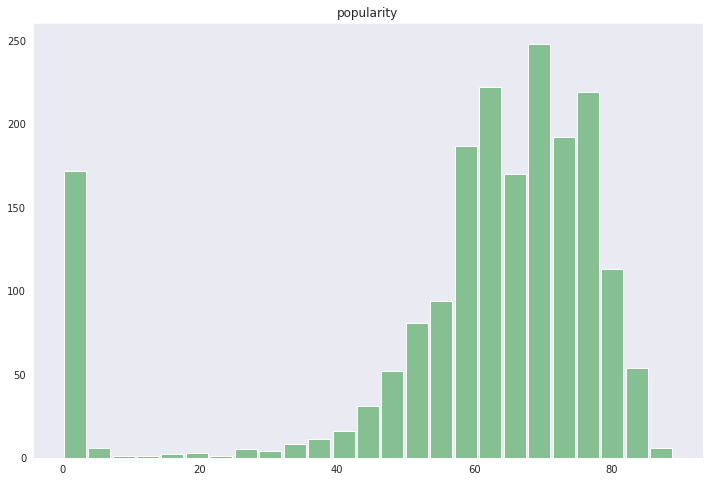

In [55]:
df.hist(column=('popularity'),bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)


#### Removing entries 
While analising the histogram, we found strange that a lot of songs had the popularity equal to zero. 
After loooking through the data, we noticed that that most of those songs were undoubtedly misclassified. For example, songs like Hello by Adele, or Despacito by Luis Fonsi, among others, were classified with zero popularity even though they are known songs for beating selling and streaming records.

In [56]:
df = df[(df.popularity > 5)]

array([[<AxesSubplot:title={'center':'popularity'}>]], dtype=object)

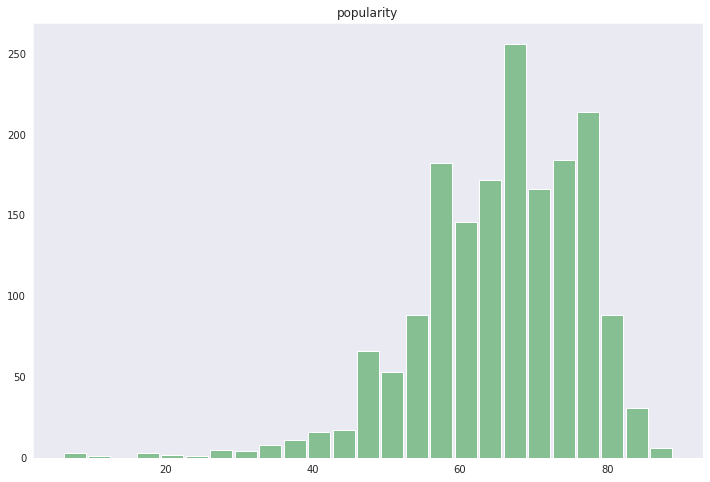

In [57]:
df.hist(column=('popularity'),bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

### Discretization 
- 11-62 not popular
- 62-72 semi-popular
- 72-89 popular

Bins:  [ 6. 62. 72. 89.]


<AxesSubplot:>

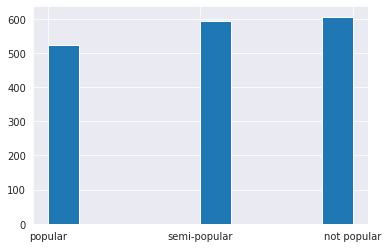

In [58]:
pop, bins = pd.qcut(df.popularity, 3, labels=["not popular", "semi-popular", "popular"], retbins = True)
print("Bins: ", bins)
pop.hist()

Adding the new class, **popularity_class**, based on popularity values

In [59]:
conditions = [
    (df['popularity'] <= 62),
    (df['popularity'] > 62) & (df['popularity'] <= 72),
    (df['popularity'] > 72)
    ]

labels = ["not popular", "semi-popular", "popular"]

#creating a new column
df['popularity_class'] = np.select(conditions, labels)


In [60]:
df.head()

,artist,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,duration_s,popularity_class
0,Britney Spears,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop,211,popular
3,Bon Jovi,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal",224,popular
4,*NSYNC,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop,201,semi-popular
6,Eminem,True,2000,86,0.949,0.661,5,-4.244,0,0.0572,0.0302,0.000000,0.0454,0.760,104.504,hip hop,284,popular
7,Robbie Williams,False,2000,68,0.708,0.772,7,-4.264,1,0.0322,0.0267,0.000000,0.4670,0.861,103.035,"pop, rock",259,semi-popular



#### Pairplot
Para nos ajudar a ver possíveis erros nos dados, e se existe alguma correlação óbvia entre as diferentes colunas

In [61]:
df['popularity_class'].unique()
num_var= ['year', 'danceability', 'energy', 'key','speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s']

#sns.pairplot(df, hue = 'popularity_class', vars= num_var)

## Análise exploratória

- Como é que os dados estão distribuídos
- Existem correlações nos dados, e o porquê de estas existirem

Para verificar possíveis correlações vamos usar um heatmap

<AxesSubplot:>

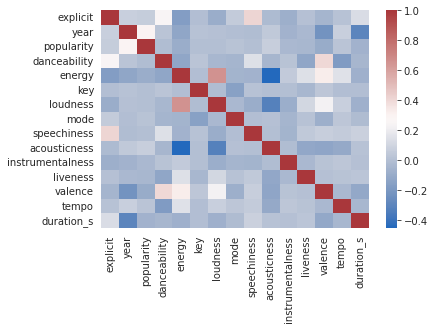

In [62]:
# Correlation between features
corr = df.corr()
#Heatmap
sns.heatmap(corr, cmap="vlag")


Observando o mapa, verificamos algumas correlações positivas entre:
- Loudness e Energy - quanto mais alta a música mais energia tem
- Valence e Danceability - músicas mais positivas tendem a ser mais dançáveis

Correlações negativas:
- Energy and Acousticness - músicas acústicas têm menos energia
- Year and Duration - ao longo dos anos as músicas tendem a ser mais curtas

## Classificação

Since some of the columns have string data, it's necessary to encode it

In [63]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#all colums except popularity and popularity_class
le = preprocessing.LabelEncoder()
le.fit(df.artist)
encoded = df
encoded['artist'] = le.transform(df.artist)

le = preprocessing.LabelEncoder()
le.fit(df.genre)
encoded = df
encoded['genre'] = le.transform(df.genre)

cols = (encoded.columns.values.tolist())
cols.remove('popularity')
cols.remove('popularity_class')

#all inputs
inputs =df[cols].values

#all popularity_class labels
all_labels = df['popularity_class'].values

print("Encoded data:")
df.head()

Encoded data:


,artist,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,duration_s,popularity_class
0,105,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,28,211,popular
3,98,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,50,224,popular
4,0,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,28,201,semi-popular
6,216,True,2000,86,0.949,0.661,5,-4.244,0,0.0572,0.0302,0.000000,0.0454,0.760,104.504,12,284,popular
7,588,False,2000,68,0.708,0.772,7,-4.264,1,0.0322,0.0267,0.000000,0.4670,0.861,103.035,38,259,semi-popular


The data is ready to be divided into training and testing sets.

In [64]:
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(inputs, all_labels, test_size=0.25, random_state=1)

## Decision Tree
Para já vamos usar um classificador básico, ou seja, sem nenhuns ajustes nos parâmetros

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import time

dt_classifier = DecisionTreeClassifier()

parameter_grid = {
                'criterion': ['gini'],
                'splitter': ['best','random'],
                'random_state': [None,1],
                }

cross_validation = StratifiedKFold(n_splits=3)

grid_search = GridSearchCV(dt_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

# start_time = time.time()
# grid_search.fit(inputs, all_labels)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# print("Time to train: %s seconds" % (time.time() - start_time))

In [66]:
# Create the classifier
dt_classifier = DecisionTreeClassifier(random_state=1)

# Train the classifier on the training set
dt_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
dt_classifier.score(testing_inputs, testing_classes)

0.3805104408352668

## LinearSVC

In [67]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linearSVC_classifier = make_pipeline(StandardScaler(),
                     LinearSVC(random_state=0, tol=1e-5, max_iter=10e5))

linearSVC_classifier.fit(training_inputs, training_classes)
linearSVC_classifier.score(testing_inputs,testing_classes)

0.41299303944315546

## K Nearest Neighbors

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import time


knn_classifier = KNeighborsClassifier()

parameter_grid = {
                'n_neighbors': [x for x in range(5,40,5)],
                'weights': ['uniform','distance'],
                'algorithm': ['auto','ball_tree','kd_tree','brute'],
                'leaf_size': [x for x in range(20,40,5)],
                'p': [1,2],
                'n_jobs': [-1],
                }

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(knn_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

# start_time = time.time()
# grid_search.fit(inputs, all_labels)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# print("Time to train: %s seconds" % (time.time() - start_time))

In [69]:
knn_classifier = KNeighborsClassifier(algorithm='kd_tree', leaf_size=25,n_jobs=-1,n_neighbors=30,p=1,weights='uniform')
knn_classifier.fit(training_inputs,training_classes)
knn_classifier.score(testing_inputs,testing_classes)

0.39443155452436196

## SVC

In [70]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
SVC_classifier = make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVC_classifier.fit(training_inputs, training_classes)
SVC_classifier.score(training_inputs,training_classes)

0.6462848297213623

## Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(training_inputs,training_classes)
random_forest_classifier.score(testing_inputs,testing_classes)

0.44547563805104406

## Voting Classifier

In [72]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

random_forest_classifier = RandomForestClassifier()
SVC_classifier = make_pipeline(StandardScaler(), SVC(gamma='auto'))
knn_classifier = KNeighborsClassifier(algorithm='kd_tree', leaf_size=25, n_jobs=-1, n_neighbors=30, p=1,
                                      weights='uniform')

eclf1 = VotingClassifier(estimators=[
         ('rf_classifier',random_forest_classifier),('svc', SVC_classifier),('knn',knn_classifier)], voting='hard')
eclf1 = eclf1.fit(training_inputs, training_classes)
eclf1.score(testing_inputs,testing_classes)

0.42691415313225056

## Neural Networks


In [73]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(inputs)
scaled_inputs = scaler.transform(inputs)
scaled_training_inputs = scaler.transform(training_inputs)
scaled_testing_inputs = scaler.transform(testing_inputs)

In [74]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import pickle
import time

nt_classifier = MLPClassifier()

parameter_grid = {
                'hidden_layer_sizes':   ([tuple([50 for y in range(0,x)]) for x in range(1,5)]+
                                        [tuple([100 for y in range(0,x)]) for x in range(1,5)]+
                                        [tuple([200 for y in range(0,x)]) for x in range(1,5)]),
                'activation': ['identity','logistic','tanh','relu'],
                'solver': ['lbfgs'],
                'random_state': [None,1],
                'alpha': [1e-5],
                'learning_rate': ['constant','invscaling','adaptive'],
                'max_iter': [10e50],
                }

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(nt_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

start_time = time.time()
grid_search.fit(scaled_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print("Time to train: %s seconds" % (time.time() - start_time))

KeyboardInterrupt: 